Reading dataset and import libs

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
# from google.colab import drive
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.layers import Input, Dense, MultiHeadAttention, Reshape, Flatten, LSTM
import yfinance as yf


In [3]:
class ETL:
    """
    ticker: str
    period: string
    test_size: float betwee 0 and 1
    n_input: int
    timestep: int
    Extracts data for stock with ticker `ticker` from yf api,
    splits the data into train and test sets by date,
    reshapes the data into np.array of shape [#weeks, 5, 1],
    converts our problem into supervised learning problem.
    """
    def __init__(self, ticker, test_size=0.2, period='max', n_input=5, timestep=5) -> None:
        self.ticker = ticker
        self.period = period
        self.test_size = test_size
        self.n_input = n_input
        self.df = self.extract_historic_data()
        self.timestep = timestep
        self.train, self.test = self.etl()
        self.X_train, self.y_train = self.to_supervised(self.train)
        self.X_test, self.y_test = self.to_supervised(self.test)

    def get_history_from_yf(self):
        t = yf.Ticker(self.ticker)
        return t.history(period=self.period)

    def extract_historic_data(self) -> pd.Series:
        """
        gets historical data from yf api.
        """
        t = yf.Ticker(self.ticker)
        history = t.history(period=self.period)
        return history.Close

    def split_data(self) -> tuple:
        """
        Splits our pd.Series into train and test series with
        test series representing test_size * 100 % of data.
        """
        data = self.extract_historic_data()
        if len(data) != 0:
            train_idx = round(len(data) * (1-self.test_size))
            train = data[:train_idx]
            test = data[train_idx:]
            train = np.array(train)
            test = np.array(test)
            return train[:, np.newaxis], test[:, np.newaxis]
        else:
            raise Exception('Data set is empty, cannot split.')

    def window_and_reshape(self, data) -> np.array:
        """
        Reformats data into shape our model needs,
        namely, [# samples, timestep, # feautures]
        samples
        """
        NUM_FEATURES = 1
        samples = int(data.shape[0] / self.timestep)
        result = np.array(np.array_split(data, samples))
        return result.reshape((samples, self.timestep, NUM_FEATURES))

    def transform(self, train, test) -> np.array:
        train_remainder = train.shape[0] % self.timestep
        test_remainder = test.shape[0] % self.timestep
        if train_remainder != 0 and test_remainder != 0:
            train = train[train_remainder:]
            test = test[test_remainder:]
        elif train_remainder != 0:
            train = train[train_remainder:]
        elif test_remainder != 0:
            test = test[test_remainder:]
        return self.window_and_reshape(train), self.window_and_reshape(test)

    def etl(self) -> tuple[np.array, np.array]:
        """
        Runs complete ETL
        """
        train, test = self.split_data()
        return self.transform(train, test)

    def to_supervised(self, train, n_out=5) -> tuple:
        """
        Converts our time series prediction problem to a
        supervised learning problem.
        """
        # flatted the data
        data = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
        X, y = [], []
        in_start = 0
        # step over the entire history one time step at a time
        for _ in range(len(data)):
            # define the end of the input sequence
            in_end = in_start + self.n_input
            out_end = in_end + n_out
            # ensure we have enough data for this instance
            if out_end <= len(data):
                x_input = data[in_start:in_end, 0]
                x_input = x_input.reshape((len(x_input), 1))
                X.append(x_input)
                y.append(data[in_end:out_end, 0])
                # move along one time step
                in_start += 1
        return np.array(X), np.array(y)

In [4]:
# drive.mount('/content/drive')
# Load your DataFrame
# data = pd.read_csv('../AzSakht/analysis_bot/backup/tvdatafeed/EURUSD_5min.csv')
etl_data = ETL('EURUSD=X')
history = etl_data.get_history_from_yf()
# print(type(data), type(history))
# print(data.columns.to_list())
# print(data['open'])
# print(history.columns.to_list())
# print(type(history.Close))
# x = history.Close
# print(x)
# print(x[0])

data = pd.DataFrame(
    {
        'open': pd.Series([x for x in history.Open]),
        'high': pd.Series([x for x in history.High]),
        'low': pd.Series([x for x in history.Low]),
        'close': pd.Series([x for x in history.Close]),
        'volume': pd.Series([x for x in history.Volume]),
    }
)

# Preprocessing
scaler = MinMaxScaler()
data['close'] = scaler.fit_transform(data['close'].values.reshape(-1, 1))

# Splitting into training and testing sets
train_size = int(0.8 * len(data))
train_data, test_data = data[:train_size], data[train_size:]

<a href="https://colab.research.google.com/github/mjmaher987/Stock-Prediction-Using-ML/blob/main/Stock.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#NBEATS

In [5]:
# Prepare data for N-BEATS
window_size = 10
X, y = [], []
for i in range(len(data) - window_size):
    X.append(data['close'][i:i+window_size])
    y.append(data['close'][i+window_size])
X = np.array(X)
y = np.array(y)

train_size = int(0.8 * len(X))
train_X, test_X = X[:train_size], X[train_size:]
train_y, test_y = y[:train_size], y[train_size:]

# Build N-BEATS model
def build_nbeats(input_shape, output_shape, num_blocks=4, num_neurons=128):
    inputs = Input(shape=input_shape)
    x = inputs
    forecasts = []
    for _ in range(num_blocks):
        for _ in range(4):  # Directly following the N-BEATS architecture
            x = Dense(num_neurons, activation='relu')(x)
        forecast = Dense(output_shape[0])(x)
        forecasts.append(forecast)
    outputs = forecasts[0]  # Use the forecast from the first block as output
    model = Model(inputs, outputs)
    return model

input_shape = (window_size, 1)
output_shape = (1,)
nbeats_model = build_nbeats(input_shape, output_shape)
nbeats_model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

# Train N-BEATS model
nbeats_model.fit(train_X, train_y, epochs=50, batch_size=32, verbose=1)

# Make predictions using the trained model
test_predictions = nbeats_model.predict(test_X)


Epoch 1/50
128/128 [==============================] - 2s 4ms/step - loss: 0.0489
Epoch 2/50
128/128 [==============================] - 1s 5ms/step - loss: 0.0356
Epoch 3/50
128/128 [==============================] - 1s 5ms/step - loss: 0.0355
Epoch 4/50
128/128 [==============================] - 1s 5ms/step - loss: 0.0358
Epoch 5/50
128/128 [==============================] - 1s 4ms/step - loss: 0.0353
Epoch 6/50
128/128 [==============================] - 0s 3ms/step - loss: 0.0354
Epoch 7/50
128/128 [==============================] - 0s 2ms/step - loss: 0.0355
Epoch 8/50
128/128 [==============================] - 0s 2ms/step - loss: 0.0354
Epoch 9/50
128/128 [==============================] - 0s 4ms/step - loss: 0.0354
Epoch 10/50
128/128 [==============================] - 0s 2ms/step - loss: 0.0353
Epoch 11/50
128/128 [==============================] - 0s 2ms/step - loss: 0.0352
Epoch 12/50
128/128 [==============================] - 0s 3ms/step - loss: 0.0354
Epoch 13/50
128/128 [====

In [6]:
reshaped_test_predictions = test_predictions[:, -1, :]

In [7]:
mae = mean_absolute_error(test_y, reshaped_test_predictions)
rmse = mean_squared_error(test_y, reshaped_test_predictions, squared=False)
print(f"Mean Absolute Error: {mae}")
print(f"Root Mean Squared Error: {rmse}")

Mean Absolute Error: 0.22202300001507885
Root Mean Squared Error: 0.24191412801511494


#NHEATS

In [8]:

X = data[['open', 'high', 'low', 'volume']].values
y = data['close'].values

train_size = int(0.7 * len(X))
val_size = int(0.15 * len(X))
train_X, test_X, train_y, test_y = X[:train_size], X[train_size:], y[:train_size], y[train_size:]
train_X, val_X, train_y, val_y = train_X[:train_size - val_size], train_X[train_size - val_size:], \
                                  train_y[:train_size - val_size], train_y[train_size - val_size:]

# Normalize data
scaler_X = MinMaxScaler()
train_X = scaler_X.fit_transform(train_X)
val_X = scaler_X.transform(val_X)
test_X = scaler_X.transform(test_X)

scaler_y = MinMaxScaler()
train_y = scaler_y.fit_transform(train_y.reshape(-1, 1)).flatten()
val_y = scaler_y.transform(val_y.reshape(-1, 1)).flatten()
test_y = scaler_y.transform(test_y.reshape(-1, 1)).flatten()

# NHITS Model
def build_nhits(input_shape):
    model = tf.keras.Sequential([
        Dense(128, activation='relu', input_shape=(input_shape,)),
        Dense(64, activation='relu'),
        Dense(1)
    ])
    return model

nhits_model = build_nhits(train_X.shape[1])
nhits_model.compile(optimizer='adam', loss='mean_squared_error')

nhits_model.fit(train_X, train_y, epochs=50, batch_size=32, validation_data=(val_X, val_y), verbose=1)

nhits_predictions = nhits_model.predict(test_X)

# Calculate MAE and RMSE for NHITS
nhits_mae = mean_absolute_error(test_y, nhits_predictions)
nhits_rmse = mean_squared_error(test_y, nhits_predictions, squared=False)
print(f"NHITS Mean Absolute Error: {nhits_mae}")
print(f"NHITS Root Mean Squared Error: {nhits_rmse}")




Epoch 1/50
89/89 [==============================] - 1s 3ms/step - loss: 0.0087 - val_loss: 0.0221
Epoch 2/50
89/89 [==============================] - 0s 2ms/step - loss: 2.0301e-04 - val_loss: 0.0180
Epoch 3/50
89/89 [==============================] - 0s 2ms/step - loss: 1.7979e-04 - val_loss: 0.0165
Epoch 4/50
89/89 [==============================] - 0s 2ms/step - loss: 1.6929e-04 - val_loss: 0.0159
Epoch 5/50
89/89 [==============================] - 0s 1ms/step - loss: 1.6341e-04 - val_loss: 0.0147
Epoch 6/50
89/89 [==============================] - 0s 1ms/step - loss: 1.6502e-04 - val_loss: 0.0147
Epoch 7/50
89/89 [==============================] - 0s 1ms/step - loss: 1.6820e-04 - val_loss: 0.0146
Epoch 8/50
89/89 [==============================] - 0s 2ms/step - loss: 1.6448e-04 - val_loss: 0.0146
Epoch 9/50
89/89 [==============================] - 0s 2ms/step - loss: 1.6478e-04 - val_loss: 0.0145
Epoch 10/50
89/89 [==============================] - 0s 1ms/step - loss: 1.8430e-04 - 

#RNN

In [9]:
# RNN Model
def build_rnn(input_shape):
    model = tf.keras.Sequential([
        tf.keras.layers.LSTM(64, input_shape=(input_shape, 1), activation='relu'),
        tf.keras.layers.Dense(1)
    ])
    return model

train_X_rnn = train_X.reshape(train_X.shape[0], train_X.shape[1], 1)
val_X_rnn = val_X.reshape(val_X.shape[0], val_X.shape[1], 1)
test_X_rnn = test_X.reshape(test_X.shape[0], test_X.shape[1], 1)

rnn_model = build_rnn(train_X_rnn.shape[1])
rnn_model.compile(optimizer='adam', loss='mean_squared_error')

rnn_model.fit(train_X_rnn, train_y, epochs=50, batch_size=32, validation_data=(val_X_rnn, val_y), verbose=1)


# Evaluate RNN models
rnn_predictions = rnn_model.predict(test_X_rnn)

# Calculate MAE and RMSE for RNN
rnn_mae = mean_absolute_error(test_y, rnn_predictions)
rnn_rmse = mean_squared_error(test_y, rnn_predictions, squared=False)
print(f"RNN Mean Absolute Error: {rnn_mae}")
print(f"RNN Root Mean Squared Error: {rnn_rmse}")


Epoch 1/50
89/89 [==============================] - 2s 12ms/step - loss: 0.0606 - val_loss: 0.1105
Epoch 2/50
89/89 [==============================] - 0s 5ms/step - loss: 0.0031 - val_loss: 0.0300
Epoch 3/50
89/89 [==============================] - 1s 6ms/step - loss: 2.7359e-04 - val_loss: 0.0215
Epoch 4/50
89/89 [==============================] - 1s 6ms/step - loss: 2.1061e-04 - val_loss: 0.0191
Epoch 5/50
89/89 [==============================] - 0s 5ms/step - loss: 2.0460e-04 - val_loss: 0.0180
Epoch 6/50
89/89 [==============================] - 0s 3ms/step - loss: 2.0003e-04 - val_loss: 0.0175
Epoch 7/50
89/89 [==============================] - 0s 3ms/step - loss: 2.1444e-04 - val_loss: 0.0167
Epoch 8/50
89/89 [==============================] - 0s 5ms/step - loss: 2.0448e-04 - val_loss: 0.0164
Epoch 9/50
89/89 [==============================] - 0s 5ms/step - loss: 1.9336e-04 - val_loss: 0.0169
Epoch 10/50
89/89 [==============================] - 0s 5ms/step - loss: 2.0066e-04 - val

#LSTM

In [10]:

# LSTM Model
def build_lstm(input_shape):
    model = tf.keras.Sequential([
        LSTM(64, input_shape=input_shape, activation='relu', return_sequences=True),
        LSTM(32, activation='relu'),
        Dense(1)
    ])
    return model

train_X_lstm = train_X.reshape(train_X.shape[0], train_X.shape[1], 1)
test_X_lstm = test_X.reshape(test_X.shape[0], test_X.shape[1], 1)

lstm_model = build_lstm(train_X_lstm.shape[1:])
lstm_model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

lstm_model.fit(train_X_lstm, train_y, epochs=50, batch_size=32, verbose=1)

lstm_predictions = lstm_model.predict(test_X_lstm)

# Calculate MAE and RMSE for LSTM
lstm_mae = mean_absolute_error(test_y, lstm_predictions)
lstm_rmse = mean_squared_error(test_y, lstm_predictions, squared=False)
print(f"LSTM Mean Absolute Error: {lstm_mae}")
print(f"LSTM Root Mean Squared Error: {lstm_rmse}")


Epoch 1/50
89/89 [==============================] - 3s 5ms/step - loss: 0.0547
Epoch 2/50
89/89 [==============================] - 1s 7ms/step - loss: 0.0027
Epoch 3/50
89/89 [==============================] - 0s 5ms/step - loss: 8.1523e-04
Epoch 4/50
89/89 [==============================] - 1s 6ms/step - loss: 2.9566e-04
Epoch 5/50
89/89 [==============================] - 0s 5ms/step - loss: 2.3278e-04
Epoch 6/50
89/89 [==============================] - 0s 5ms/step - loss: 2.0591e-04
Epoch 7/50
89/89 [==============================] - 0s 3ms/step - loss: 2.0859e-04
Epoch 8/50
89/89 [==============================] - 0s 3ms/step - loss: 2.0075e-04
Epoch 9/50
89/89 [==============================] - 0s 3ms/step - loss: 2.0626e-04
Epoch 10/50
89/89 [==============================] - 0s 4ms/step - loss: 2.1091e-04
Epoch 11/50
89/89 [==============================] - 0s 4ms/step - loss: 1.9090e-04
Epoch 12/50
89/89 [==============================] - 0s 3ms/step - loss: 1.9266e-04
Epoch 13/

#Transformers

In [11]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0, epsilon=1e-6, attention_axes=None, kernel_size=1):
  """
  Creates a single transformer block.
  """
  x = layers.LayerNormalization(epsilon=epsilon)(inputs)
  x = layers.MultiHeadAttention(
      key_dim=head_size, num_heads=num_heads, dropout=dropout,
      attention_axes=attention_axes
      )(x, x)
  x = layers.Dropout(dropout)(x)
  res = x + inputs

    # Feed Forward Part
  x = layers.LayerNormalization(epsilon=epsilon)(res)
  x = layers.Conv1D(filters=ff_dim, kernel_size=kernel_size, activation="relu")(x)
  x = layers.Dropout(dropout)(x)
  x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=kernel_size)(x)
  return x + res

def build_transfromer(head_size, num_heads, ff_dim, num_trans_blocks, mlp_units, dropout=0, mlp_dropout=0, attention_axes=None, epsilon=1e-6, kernel_size=1):
  """
  Creates final model by building many transformer blocks.
  """
  n_timesteps, n_features, n_outputs = 5, 1, 5
  inputs = tf.keras.Input(shape=(n_timesteps, n_features))
  x = inputs
  for _ in range(num_trans_blocks):
    x = transformer_encoder(x, head_size=head_size, num_heads=num_heads, ff_dim=ff_dim, dropout=dropout, attention_axes=attention_axes, kernel_size=kernel_size, epsilon=epsilon)

  x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
  for dim in mlp_units:
    x = layers.Dense(dim, activation="relu")(x)
    x = layers.Dropout(mlp_dropout)(x)

  outputs = layers.Dense(n_outputs)(x)
  return tf.keras.Model(inputs, outputs)


transformer_model = build_transfromer(head_size=128, num_heads=4, ff_dim=2, num_trans_blocks=4, mlp_units=[256], mlp_dropout=0.10, dropout=0.10, attention_axes=1)

def fit_transformer(transformer: tf.keras.Model):
  """
  Compiles and fits our transformer.
  """
  transformer.compile(
    loss="mse",
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    metrics=["mae", 'mape'])

  callbacks = [tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)]
  hist = transformer.fit(etl_data.X_train, etl_data.y_train, batch_size=32, epochs=25, verbose=1, callbacks=callbacks)
  return hist


hist = fit_transformer(transformer_model)

Epoch 1/25
128/128 [==============================] - 8s 13ms/step - loss: 0.1064 - mae: 0.2027 - mape: 16.0355
Epoch 2/25
128/128 [==============================] - 2s 12ms/step - loss: 0.0128 - mae: 0.0890 - mape: 7.0143
Epoch 3/25
128/128 [==============================] - 2s 16ms/step - loss: 0.0088 - mae: 0.0742 - mape: 5.8416
Epoch 4/25
128/128 [==============================] - 2s 13ms/step - loss: 0.0076 - mae: 0.0684 - mape: 5.3745
Epoch 5/25
128/128 [==============================] - 2s 17ms/step - loss: 0.0068 - mae: 0.0652 - mape: 5.1299
Epoch 6/25
128/128 [==============================] - 1s 11ms/step - loss: 0.0060 - mae: 0.0612 - mape: 4.8125
Epoch 7/25
128/128 [==============================] - 1s 11ms/step - loss: 0.0055 - mae: 0.0585 - mape: 4.5957
Epoch 8/25
128/128 [==============================] - 2s 13ms/step - loss: 0.0050 - mae: 0.0560 - mape: 4.3995
Epoch 9/25
128/128 [==============================] - 1s 11ms/step - loss: 0.0047 - mae: 0.0540 - mape: 4.2425


In [21]:
transformer_predictions = transformer_model.predict(etl_data.X_test)
print(type(etl_data.X_test))

print(transformer_predictions)

transformer_mae = mean_absolute_error(etl_data.y_test, transformer_predictions)
transformer_rmse = mean_squared_error(etl_data.y_test, transformer_predictions, squared=False)
print(f"Transformer Mean Absolute Error: {transformer_mae}")
print(f"Transformet Mean Squared Error: {transformer_rmse}")


32/32 [==============================] - 0s 8ms/step
<class 'numpy.ndarray'>
[[1.0856802 1.0877448 1.0866799 1.0897294 1.0916995]
 [1.0848798 1.0863029 1.085455  1.0882771 1.0908458]
 [1.0851817 1.0867019 1.0861878 1.0888226 1.0912251]
 ...
 [1.0816963 1.0833149 1.0823959 1.0852793 1.0876963]
 [1.080456  1.0820504 1.0812896 1.0840869 1.0865066]
 [1.0803833 1.0819651 1.0811439 1.0840007 1.0864366]]
Transformer Mean Absolute Error: 0.00999224884068872
Transformet Mean Squared Error: 0.012573678450425136


In [13]:
import matplotlib.pyplot as plt


def plot_results(test, preds, df, image_path=None, title_suffix=None, xlabel='EURUSD price'):
  """
  Plots training data in blue, actual values in red, and predictions in green,
  over time.
  """
  fig, ax = plt.subplots(figsize=(20,6))

  plot_test = test[1:]
  plot_preds = preds[1:]
  x = df[-(plot_test.shape[0]*plot_test.shape[1]):].index
  plot_test = plot_test.reshape((plot_test.shape[0]*plot_test.shape[1], 1))
  plot_preds = plot_preds.reshape((plot_test.shape[0]*plot_test.shape[1], 1))
  ax.plot(x, plot_test, label='actual')
  ax.plot(x, plot_preds, label='preds')

  if title_suffix==None:
    ax.set_title('Predictions vs. Actual')
  else:
    ax.set_title(f'Predictions vs. Actual, {title_suffix}')

  ax.set_xlabel('Date')
  ax.set_ylabel(xlabel)
  ax.legend()
  if image_path != None:
    imagedir = './result_plots'
    plt.savefig(f'{imagedir}/{image_path}.png')
  plt.show()

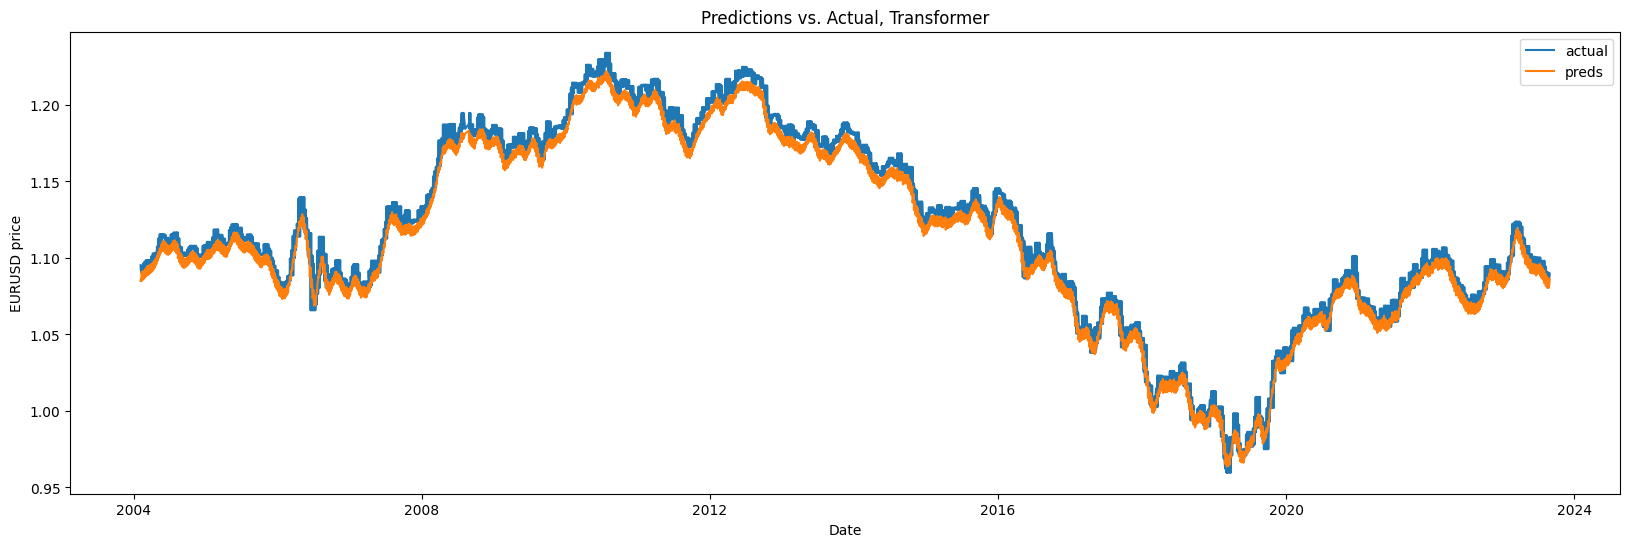

In [14]:
plot_results(etl_data.X_test, transformer_predictions, etl_data.df, title_suffix='Transformer')

Save and serialize models for the bot

In [18]:
# save models for bot usage
nbeats_model.save('./model_dumps/nbeats.keras')
nhits_model.save('./model_dumps/nhits.keras')
rnn_model.save('./model_dumps/rnn.keras')
lstm_model.save('./model_dumps/lstm.keras')
transformer_model.save('./model_dumps/transformer.keras')